In [1]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:

# -------------------------------
# 1. Speed Up PyTorch on GPU
# -------------------------------
torch.backends.cudnn.benchmark = True  # Optimizes certain CNN operations

# Configuration
dataset_dir = 'Binary_Classification_Dataset'
img_height, img_width = 150, 150
num_epochs = 30
patience = 3  # Early stopping patience

# Hyperparameter Grid
hyperparams = [
    {'optimizer': 'adam',    'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'},
    {'optimizer': 'adam',    'learning_rate': 0.0001,'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'},
    {'optimizer': 'rmsprop', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'},
    {'optimizer': 'sgd',     'learning_rate': 0.01,  'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'},
    {'optimizer': 'adam',    'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'softmax'},
]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)





Using device: cuda


In [3]:
# -------------------------------
# 2. Data Preparation
# -------------------------------
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Load full dataset with training transformations (we'll split below)
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transform)
dataset_size = len(full_dataset)
print(f"Total images in dataset: {dataset_size}")

# Example: 70% train, 15% val, 15% test
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Update the transforms for validation and test sets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")



Total images in dataset: 4094
Train size: 2866, Val size: 614, Test size: 614


In [4]:
# -------------------------------
# 3. Model Definition
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, dropout, activation='sigmoid'):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input channels = 3
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # After 3 poolings for 150x150 input: feature map size ~ 128 x 18 x 18
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.activation = activation
        if activation == 'softmax':
            self.out = nn.Linear(512, 2)  # for multi-class approach
        else:
            self.out = nn.Linear(512, 1)  # for binary classification

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = self.out(x)
        return x



In [5]:
# -------------------------------
# 4. Training Function
# -------------------------------
def train_model(model, 
                train_loader, 
                val_loader, 
                criterion, 
                optimizer, 
                num_epochs, 
                patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # For BCEWithLogitsLoss, labels must be float and reshaped
            if model.activation != 'softmax':
                labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            
            # --------------------------------
            # Optional: Automatic Mixed Precision
            # --------------------------------
            # with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Evaluation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                if model.activation == 'softmax':
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                else:
                    loss = criterion(outputs, labels.float().unsqueeze(1))
                    preds = (torch.sigmoid(outputs) > 0.5).int().squeeze(1)

                running_val_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct.double() / total
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")
        
        # Early Stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model, best_acc.item()



In [6]:

# -------------------------------
# 5. Hyperparameter Search
# -------------------------------
results = []
best_global_acc = 0.0
best_global_model = None
best_global_params = None

for hp in hyperparams:
    print(f"\n=== Training with hyperparameters: {hp} ===")
    
    # Create DataLoaders for current batch size
    train_loader = DataLoader(
        train_dataset, 
        batch_size=hp['batch_size'], 
        shuffle=True,
        num_workers=4,       # More workers = faster data loading
        pin_memory=True      # Speeds up host-to-device transfer
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=hp['batch_size'], 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize the model and move it to device
    model = CNNModel(dropout=hp['dropout'], activation=hp['activation']).to(device)
    
    # Choose loss function
    if hp['activation'] == 'softmax':
        criterion = nn.CrossEntropyLoss()  
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    # Configure optimizer
    if hp['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'])
    elif hp['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=hp['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=hp['learning_rate'])
    
    # Train and evaluate the model
    model, best_val_acc = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer,
        num_epochs=num_epochs, 
        patience=patience
    )
    
    print(f"Best Validation Accuracy for {hp}: {best_val_acc:.4f}")
    results.append({'hyperparameters': hp, 'best_val_accuracy': best_val_acc})
    
    # Track the overall best model
    if best_val_acc > best_global_acc:
        best_global_acc = best_val_acc
        best_global_model = copy.deepcopy(model)
        best_global_params = hp


=== Training with hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'} ===
Epoch 1/30 | Train Loss: 0.4470 | Val Loss: 0.2649 | Val Acc: 0.8941
Epoch 2/30 | Train Loss: 0.2733 | Val Loss: 0.2467 | Val Acc: 0.9039
Epoch 3/30 | Train Loss: 0.2230 | Val Loss: 0.2426 | Val Acc: 0.9088
Epoch 4/30 | Train Loss: 0.1907 | Val Loss: 0.1937 | Val Acc: 0.9267
Epoch 5/30 | Train Loss: 0.1753 | Val Loss: 0.3328 | Val Acc: 0.8893
Epoch 6/30 | Train Loss: 0.1636 | Val Loss: 0.1847 | Val Acc: 0.9235
Epoch 7/30 | Train Loss: 0.1492 | Val Loss: 0.2844 | Val Acc: 0.9121
Early stopping triggered!
Best Validation Accuracy for {'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'}: 0.9267

=== Training with hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'} ===
Epoch 1/30 | Train Loss: 0.5260 | Val Loss: 0.3815 | Val A

In [7]:
# -------------------------------
# 6. Evaluate on Test Set
# -------------------------------
print("\n=== Evaluating Best Model on Test Set ===")
print(f"Best Hyperparameters: {best_global_params}")
print(f"Best Validation Accuracy: {best_global_acc:.4f}")

# Create a DataLoader for the test set
test_loader = DataLoader(
    test_dataset,
    batch_size=best_global_params['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Switch to eval mode
best_global_model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_global_model(inputs)

        if best_global_params['activation'] == 'softmax':
            _, preds = torch.max(outputs, 1)
        else:
            preds = (torch.sigmoid(outputs) > 0.5).int().squeeze(1)

        correct_test += torch.sum(preds == labels.data)
        total_test += labels.size(0)

test_acc = correct_test.double() / total_test
print(f"Test Accuracy: {test_acc:.4f}")
with open('results.txt', 'w') as f:
    f.write(f"Best Hyperparameters: {best_global_params}\n")
    f.write(f"Best Validation Accuracy: {best_global_acc:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")





=== Evaluating Best Model on Test Set ===
Best Hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'}
Best Validation Accuracy: 0.9495
Test Accuracy: 0.9593


In [8]:
# -------------------------------
# 7. Summarize Results
# -------------------------------
print("\n=== PyTorch Experiment Results ===")
for i, res in enumerate(results):
    print(f"Experiment {i+1}: Hyperparameters: {res['hyperparameters']} | "
          f"Best Val Accuracy: {res['best_val_accuracy']:.4f}")

# Optionally, save results to file
with open('pytorch_hyperparameter_results.txt', 'w') as f:
    for res in results:
        f.write(f"{res['hyperparameters']}: {res['best_val_accuracy']:.4f}\n")

print("\nDone!")


=== PyTorch Experiment Results ===
Experiment 1: Hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'} | Best Val Accuracy: 0.9267
Experiment 2: Hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'} | Best Val Accuracy: 0.9495
Experiment 3: Hyperparameters: {'optimizer': 'rmsprop', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'sigmoid'} | Best Val Accuracy: 0.9479
Experiment 4: Hyperparameters: {'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 64, 'dropout': 0.3, 'activation': 'sigmoid'} | Best Val Accuracy: 0.8876
Experiment 5: Hyperparameters: {'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.5, 'activation': 'softmax'} | Best Val Accuracy: 0.9430

Done!


In [9]:
# save the best model

torch.save(best_global_model.state_dict(), 'best_model.pth')

In [10]:
! pip install matplotlib

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Manually specify the model parameters used for the best model
model_dropout = 0.5
model_activation = 'sigmoid'  # or 'softmax' if that was used

# Load your model with these parameters
model = CNNModel(dropout=model_dropout, activation=model_activation).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()



CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=41472, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=512, out_features=1, bias=True)
)

Wrongly predicted image: Binary_Classification_Dataset/with_mask\0_0_0 copy 3.jpg


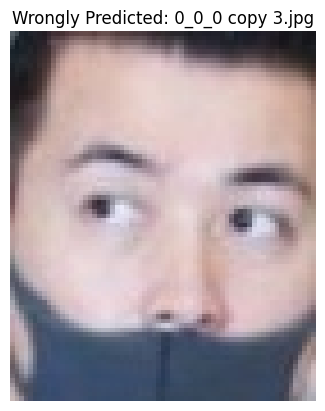

Wrongly predicted image: Binary_Classification_Dataset/with_mask\0_0_0 copy 72.jpg


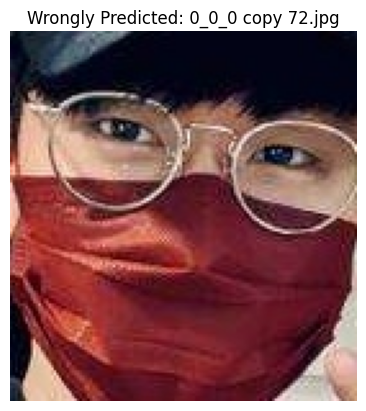

Wrongly predicted image: Binary_Classification_Dataset/with_mask\0_0_0 copy 96.jpg


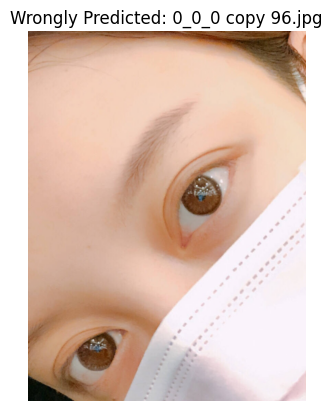

Wrongly predicted image: Binary_Classification_Dataset/with_mask\0_0_1 copy 38.jpg


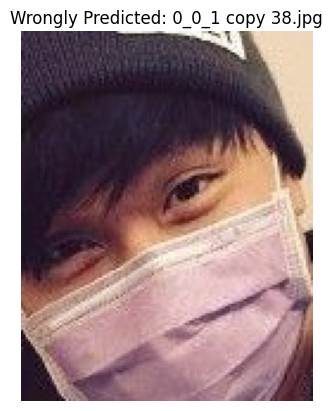

Wrongly predicted image: Binary_Classification_Dataset/with_mask\0_0_11 copy 5.jpg


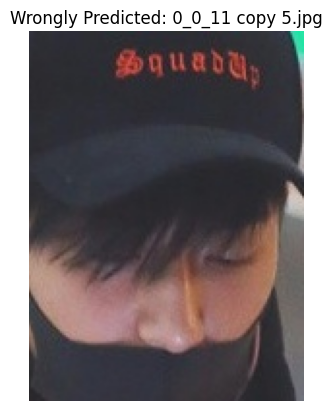

c:\Users\priya\anaconda3\envs\VR-Project\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Correctly predicted: 2102
Wrongly predicted: 63
Accuracy: 0.9709006928406466


In [12]:
# Directory with images
image_dir = 'Binary_Classification_Dataset/with_mask'
correct=0
false=0
print_count=0

# 0 is with mask, 1 is without mask
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    pil_img = Image.open(image_path).convert('RGB')
    # Prepare the image for prediction
    input_tensor = val_test_transform(pil_img).unsqueeze(0).to(device)
    
    output = model(input_tensor)
    if model_activation == 'softmax':
        _, pred = torch.max(output, 1)
        pred = pred.item()
    else:
        pred = (torch.sigmoid(output) > 0.5).int().item()
    
    # print(f"Prediction for {image_name}: {'with_mask' if int(pred) == 0 else 'without_mask'}")
    if pred == 1:
        false+=1
        if print_count<5:
            print(f"Wrongly predicted image: {image_path}")
            # Display the image inline using matplotlib
            plt.imshow(pil_img)
            plt.title(f"Wrongly Predicted: {image_name}")
            plt.axis('off')
            plt.show()
            print_count+=1
    else:
        correct+=1
    

print(f"Correctly predicted: {correct}")
print(f"Wrongly predicted: {false}")

print(f"Accuracy: {correct/(correct+false)}")

Wrongly predicted image: Binary_Classification_Dataset/without_mask\0_0_anhu_0103.jpg


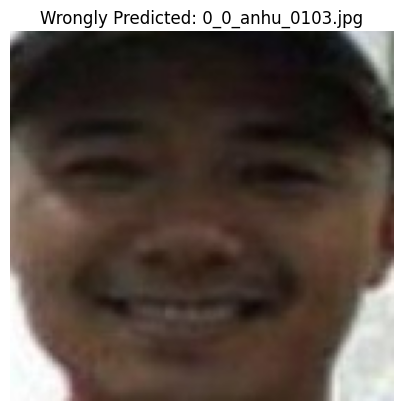

Wrongly predicted image: Binary_Classification_Dataset/without_mask\0_0_anhu_0201.jpg


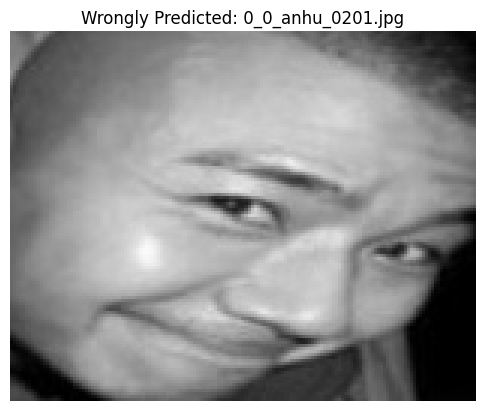

Wrongly predicted image: Binary_Classification_Dataset/without_mask\0_0_baibaihe_0085.jpg


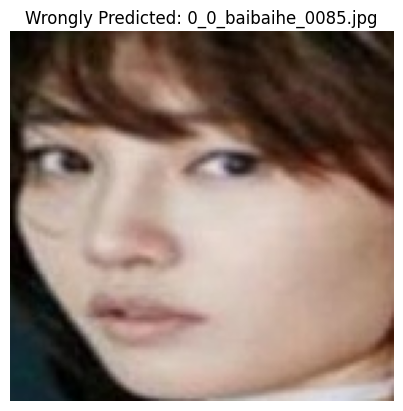

Wrongly predicted image: Binary_Classification_Dataset/without_mask\0_0_cengyongti_0042.jpg


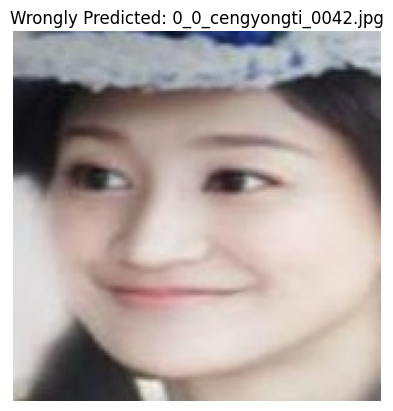

Wrongly predicted image: Binary_Classification_Dataset/without_mask\0_0_chenxiang_0071.jpg


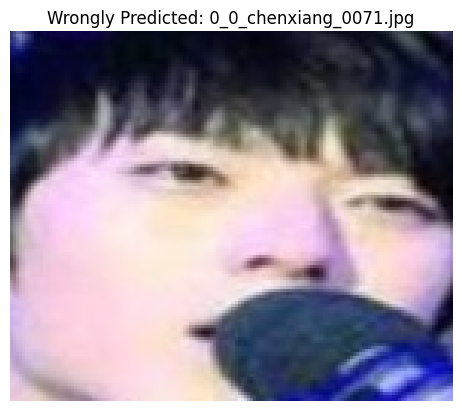

Correctly predicted: 1801
Wrongly predicted: 129
Accuracy: 0.933160621761658


In [13]:
# Directory with images
image_dir = 'Binary_Classification_Dataset/without_mask'
correct=0
false=0
print_count=0

# 0 is with mask, 1 is without mask
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    pil_img = Image.open(image_path).convert('RGB')
    # Prepare the image for prediction
    input_tensor = val_test_transform(pil_img).unsqueeze(0).to(device)
    
    output = model(input_tensor)
    if model_activation == 'softmax':
        _, pred = torch.max(output, 1)
        pred = pred.item()
    else:
        pred = (torch.sigmoid(output) > 0.5).int().item()
    
    # print(f"Prediction for {image_name}: {'with_mask' if int(pred) == 0 else 'without_mask'}")
    if pred == 0:
        false+=1
        if print_count<5:
            print(f"Wrongly predicted image: {image_path}")
            # Display the image inline using matplotlib
            plt.imshow(pil_img)
            plt.title(f"Wrongly Predicted: {image_name}")
            plt.axis('off')
            plt.show()
            print_count+=1
    else:
        correct+=1
    

print(f"Correctly predicted: {correct}")
print(f"Wrongly predicted: {false}")

print(f"Accuracy: {correct/(correct+false)}")

In [14]:
# Assumes that your test_dataset was already created earlier in the notebook
# and that your best model was saved using torch.save()

import torch
from torch.utils.data import DataLoader

# Manually set the best model parameters (adjust if necessary)
model_dropout = 0.5
model_activation = 'sigmoid'  # Use 'softmax' if that was used in the best model

# Load the best model from file
best_model = CNNModel(dropout=model_dropout, activation=model_activation).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Create a DataLoader for the test set (you can adjust the batch size as needed)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,   # Use an appropriate batch size
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Evaluate the best model on the test set and calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        if model_activation == 'softmax':
            _, preds = torch.max(outputs, 1)
        else:
            preds = (torch.sigmoid(outputs) > 0.5).int().squeeze(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"correct: {correct}")
print(f"total: {total}")
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

correct: 589
total: 614
Test Accuracy: 0.9593
